In [21]:
import re
import unicodedata
import pandas as pd
import nltk
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from nltk import ngrams

import acquire as acq
import prepare as prep

import env
from sqlalchemy import text, create_engine

## Spam Data

### a. Load the spam data set.

In [2]:
spam_query = """
        select *
        from spam;
        """

In [6]:
def spam_data(SQL_query):
    """
    This function will:
    - take in a SQL_query
    - create a db_url to mySQL
    - return a df of the given query from the spam_db
    """
    url = env.get_db_url('spam_db')
    
    return pd.read_sql(SQL_query, url, index_col='id')

In [7]:
df = spam_data(spam_query)

df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', '4', 'ltgt']

def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [9]:
# we can do that process with a join on a Series and not just a list
# we will do that for ham words, spam words, and all words
# we will pass our basic cleaning on top of that

ham_words = clean(' '.join(df[df.label=="ham"]['text']))
spam_words = clean(' '.join(df[df.label=="spam"]['text']))
all_words = clean(' '.join(df['text']))

In [11]:
# let's get some sights on word frequency by taking our words back apart
# we will split each set of words by the spaces,
# turn that into a list, cast that list as a Series,
# and then take the value counts of that Series
# We will do this for each type of word present

ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [12]:
pd.concat([ham_freq, spam_freq, all_freq], axis=1)#.fillna(0).astype(int)

,0,1,2
im,449.0,13.0,462
get,314.0,83.0,397
go,273.0,31.0,304
ok,272.0,5.0,277
dont,257.0,22.0,279
...,...,...,...
resub,NaN,1.0,1
expired,NaN,1.0,1
9153,NaN,1.0,1
okmail,NaN,1.0,1


In [13]:
# lets combine all 3 dfs horizontally
# fill any missing values with zero
# convert the resulting df to contain only integer values:

word_counts = pd.concat([ham_freq, spam_freq, all_freq], axis=1).fillna(0).astype(int)

# rename the col names
word_counts.columns = ['ham', 'spam', 'all']

word_counts.head()

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279


In [14]:
# sort by 'ham' and 'spam' columns

word_counts.sort_values(['ham', 'spam', 'all'], ascending=False)

,ham,spam,all
im,449,13,462
get,314,83,397
go,273,31,304
ok,272,5,277
dont,257,22,279
...,...,...,...
resub,0,1,1
expired,0,1,1
9153,0,1,1
okmail,0,1,1


In [15]:
# setting basic style parameters for matplotlib
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-darkgrid')

<AxesSubplot:>

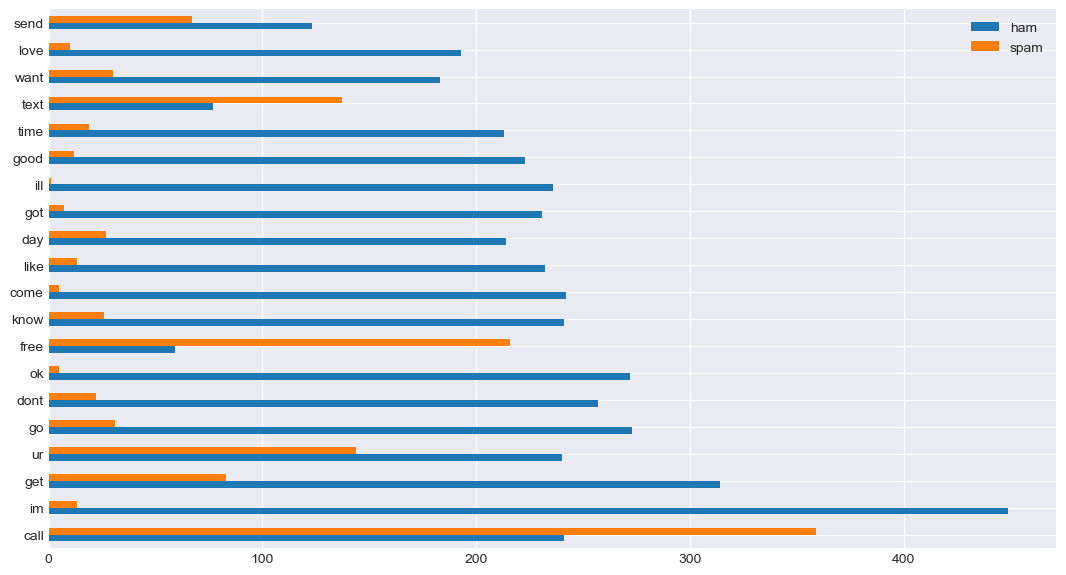

In [16]:
word_counts.sort_values('all', ascending=False)[['ham', 'spam']].head(20).plot.barh()

In [17]:
word_counts.sort_values('all', ascending=False).head(20)\
.apply(lambda row: row/row['all'], axis=1)

,ham,spam,all
call,0.401667,0.598333,1.0
im,0.971861,0.028139,1.0
get,0.790932,0.209068,1.0
ur,0.625000,0.375000,1.0
go,0.898026,0.101974,1.0
dont,0.921147,0.078853,1.0
ok,0.981949,0.018051,1.0
free,0.214545,0.785455,1.0
know,0.902622,0.097378,1.0
come,0.979757,0.020243,1.0


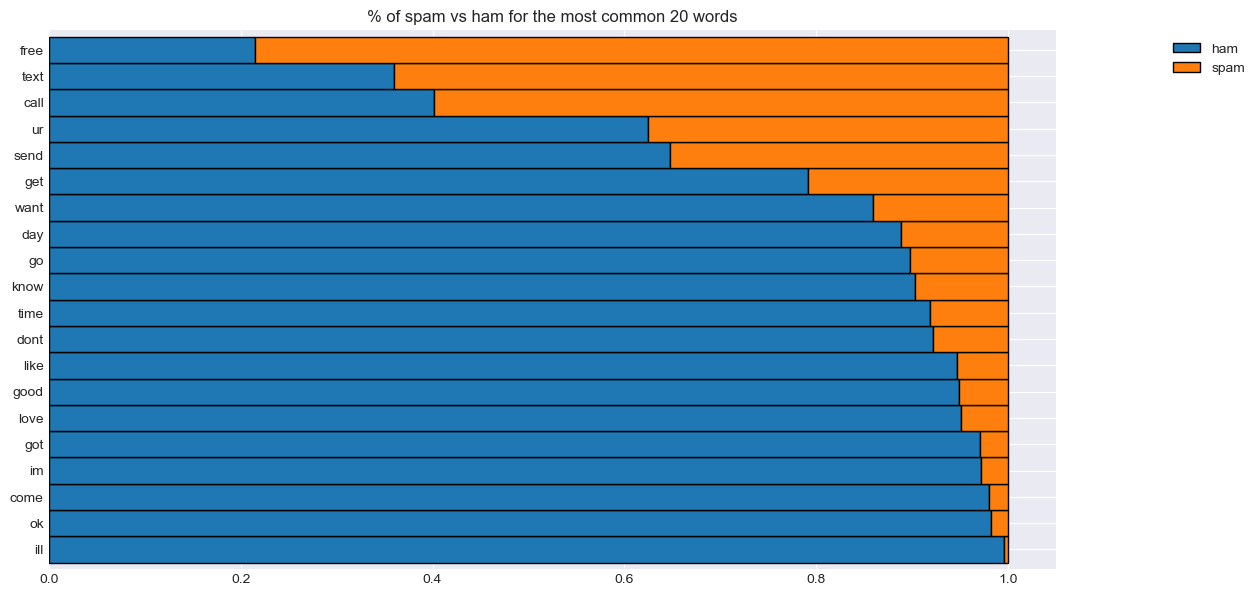

In [18]:
(word_counts.sort_values('all', ascending=False)
.head(20)
.apply(lambda row: row/row['all'], axis=1)
.drop(columns='all')
.sort_values(by='spam')
.plot.barh(stacked=True, width=1, ec='black')
)


plt.title('% of spam vs ham for the most common 20 words')
plt.legend(bbox_to_anchor=(1.2, 1.0),loc='upper right')
plt.show()

### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?

<AxesSubplot:>

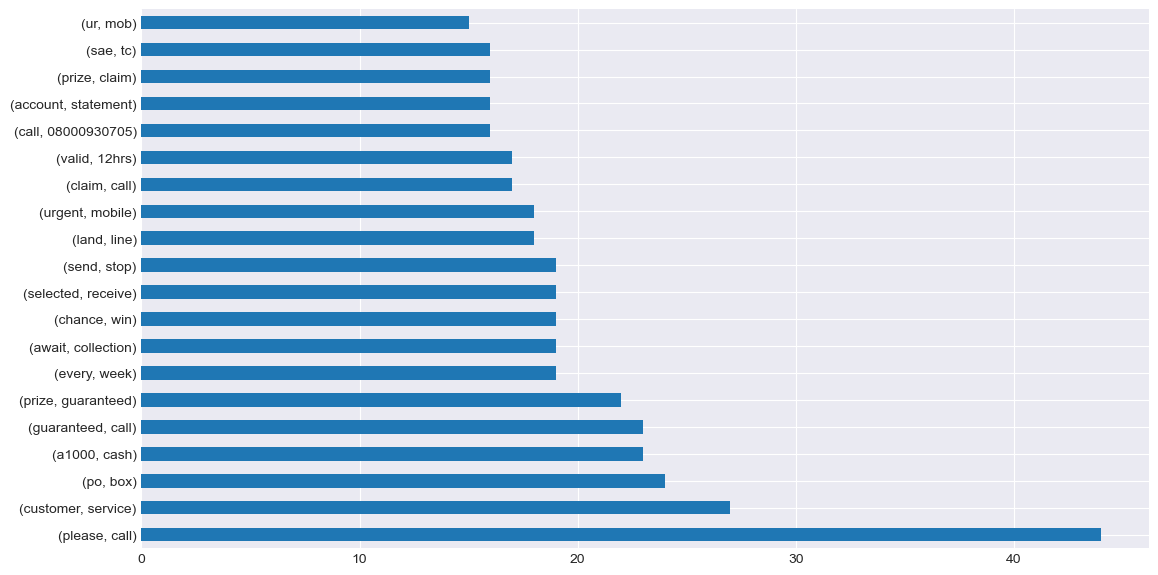

In [19]:
pd.Series(nltk.bigrams(spam_words)).value_counts().head(20).plot.barh()

In [ ]:
pd.Series(nltk.bigrams(spam_words)).value_counts().plot.barh()
pd.Series(nltk.bigrams(ham_words)).value_counts().plot.barh()

<AxesSubplot:>

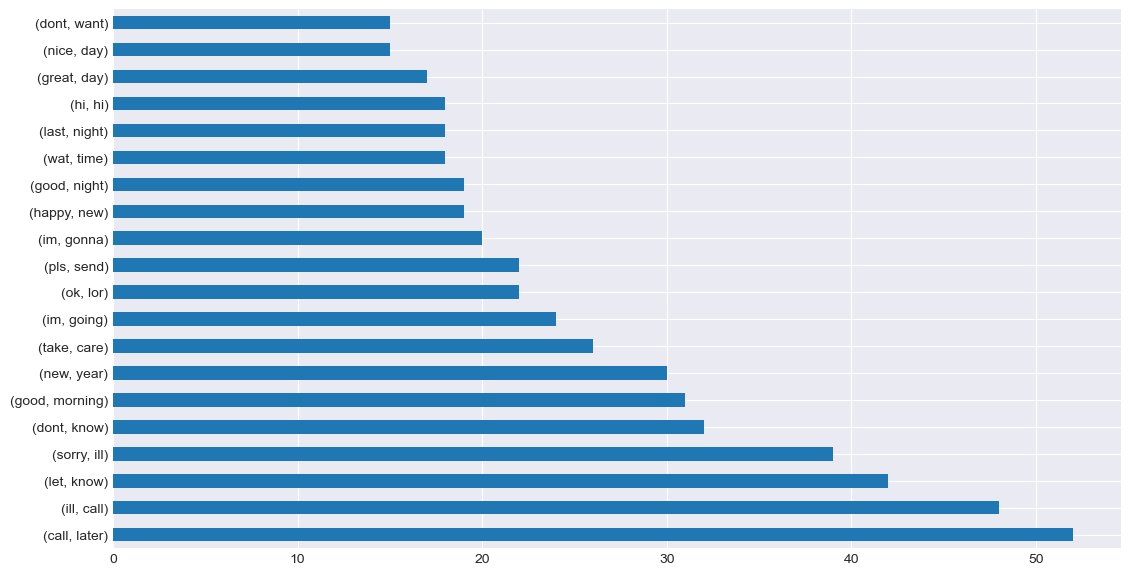

In [20]:
pd.Series(nltk.bigrams(ham_words)).value_counts().head(20).plot.barh()

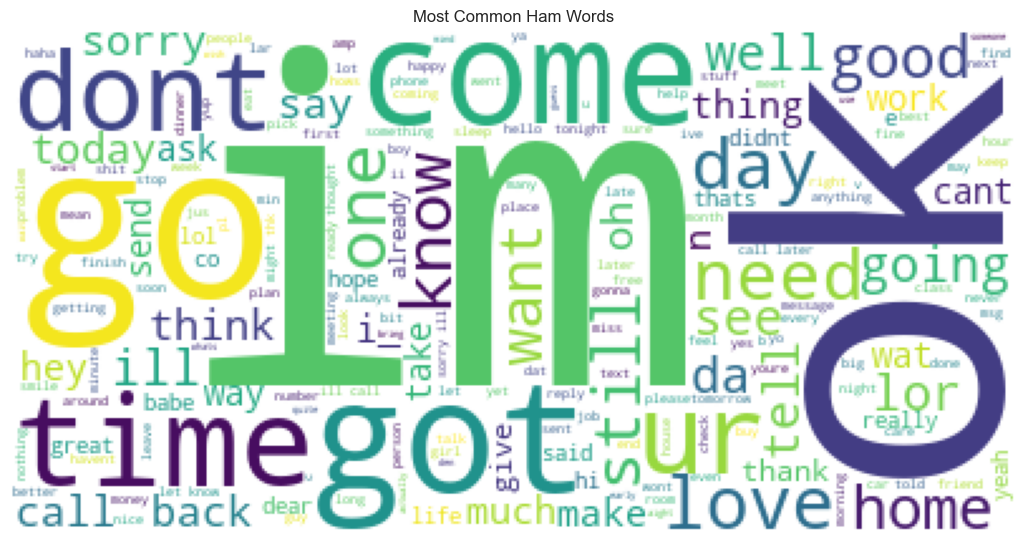

In [21]:
img = WordCloud(background_color='white').generate(' '.join(ham_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

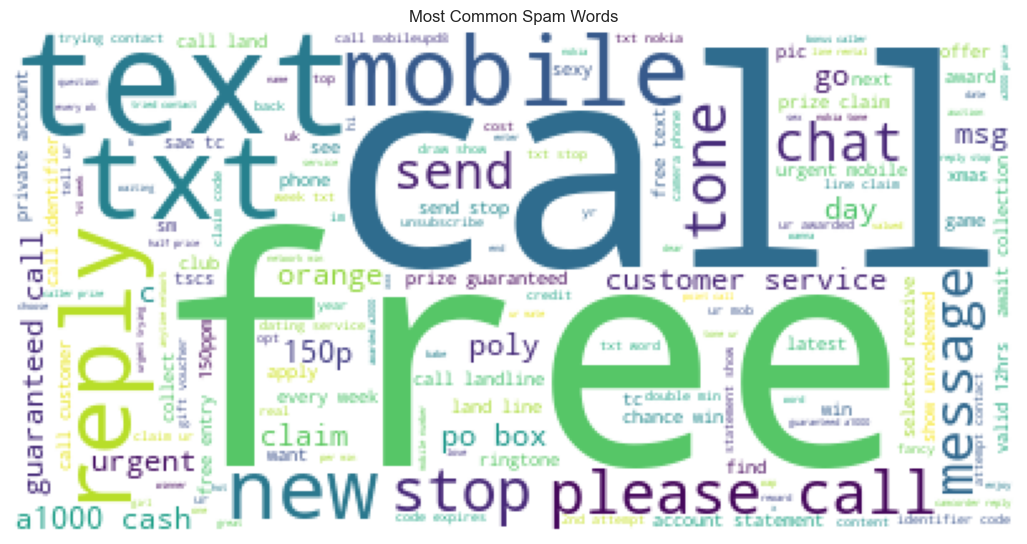

In [22]:
img = WordCloud(background_color='white').generate(' '.join(spam_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Spam Words')
plt.show()

### c. Is there any overlap in the bigrams for the spam data and the ham data?

In [23]:
# Convert the bigrams to sets
spam_bigrams = set(nltk.bigrams(spam_words))
ham_bigrams = set(nltk.bigrams(ham_words))

# Find the intersection of the two sets
overlap = spam_bigrams.intersection(ham_bigrams)

# Print the number of overlapping bigrams
print(len(overlap))

180


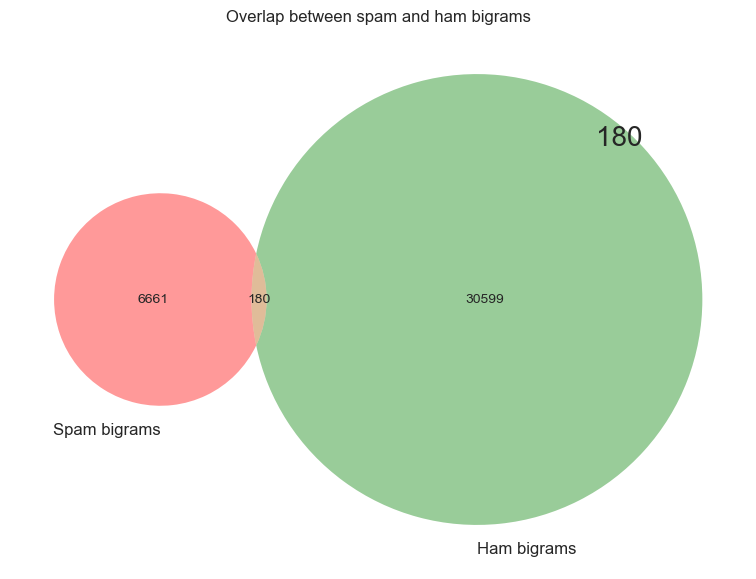

In [26]:
# Convert the bigrams to sets
spam_bigrams = set(nltk.bigrams(spam_words))
ham_bigrams = set(nltk.bigrams(ham_words))

# Find the intersection of the two sets
overlap = spam_bigrams.intersection(ham_bigrams)

# Create the Venn diagram
venn2([spam_bigrams, ham_bigrams], ('Spam bigrams', 'Ham bigrams'))
plt.title('Overlap between spam and ham bigrams')

# Add the overlap count to the diagram
plt.annotate(str(len(overlap)), xy=(0.4, 0.35), fontsize=20)

# Show the plot
plt.show()

### d. Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.

<AxesSubplot:>

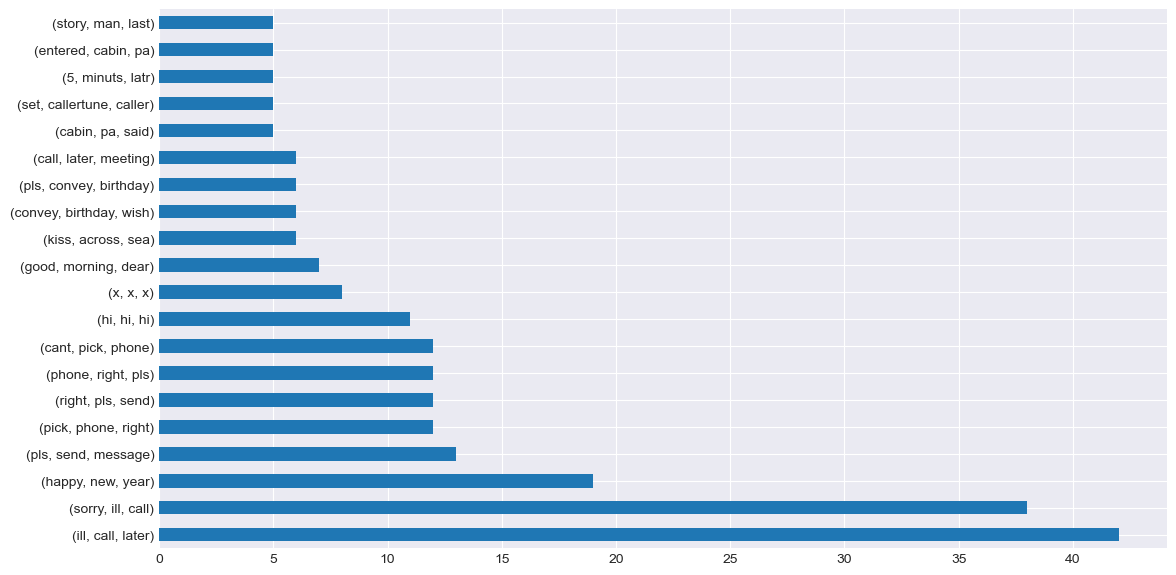

In [28]:
pd.Series(nltk.trigrams(ham_words)).value_counts().head(20).plot.barh()

<AxesSubplot:>

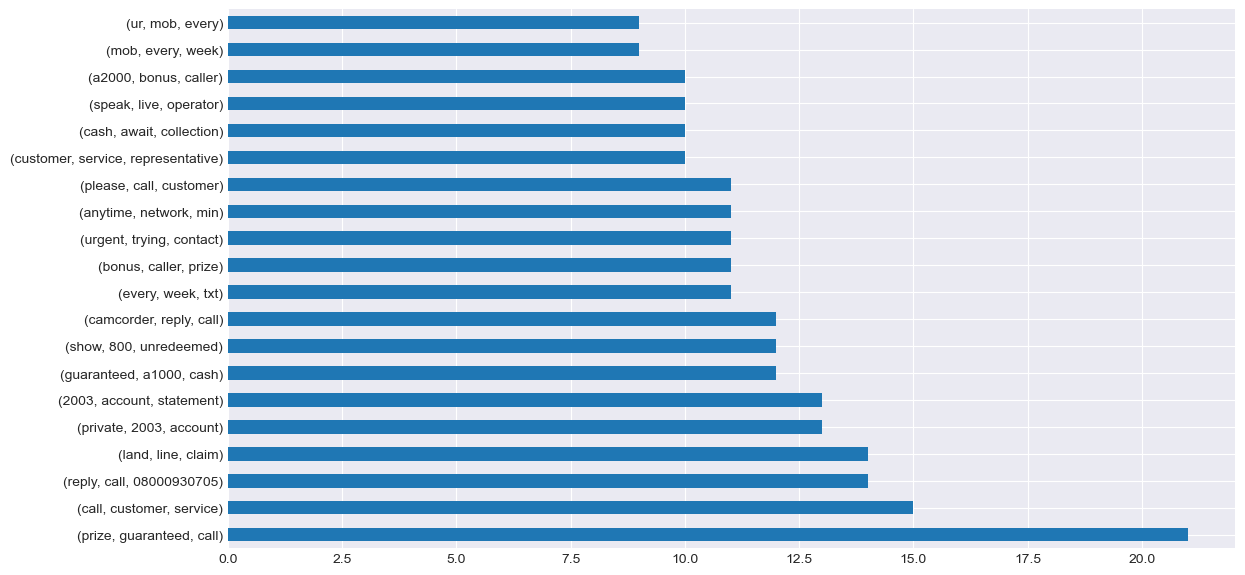

In [29]:
pd.Series(nltk.trigrams(spam_words)).value_counts().head(20).plot.barh()

## 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [2]:
final_df = prep.get_clean_news_articles()

In [3]:
final_df.head()

,title,original,clean,tokenized,stemmed,lemmatized
0,"Sensex, Nifty end at fresh closing highs",Benchmark indices Sensex and Nifty ended at re...,benchmark indices sensex and nifty ended at re...,benchmark indices sensex and nifty ended at re...,benchmark indic sensex and nifti end at record...,benchmark indic sensex and nifti end at record...
1,TIME releases list of the world's 100 most inf...,TIME magazine has released its annual list of ...,time magazine has released its annual list of ...,time magazine has released its annual list of ...,time magazin ha releas it annual list of the w...,time magazin ha releas it annual list of the w...
2,Which are the world's top 10 airlines accordin...,Singapore Airlines is the world's best airline...,singapore airlines is the world's best airline...,singapore airlines is the world ' s best airli...,singapor airlin is the world ' s best airlin a...,singapor airlin is the world ' s best airlin a...
3,"Grab lays off over 1,000 employees",Singapore-based ride-hailing and food delivery...,singaporebased ridehailing and food delivery a...,singaporebased ridehailing and food delivery a...,singaporebas ridehail and food deliveri app gr...,singaporebas ridehail and food deliveri app gr...
4,"Loves India, is a fan of PM: Paytm Founder on ...",Paytm Founder Vijay Shekhar Sharma shared a vi...,paytm founder vijay shekhar sharma shared a vi...,paytm founder vijay shekhar sharma shared a vi...,paytm founder vijay shekhar sharma share a vid...,paytm founder vijay shekhar sharma share a vid...


In [8]:
# final_df.iloc[1].lemmatized

"time magazin ha releas it annual list of the world ' s 100 most influenti compani which featur openai spacex chesscom googl deepmind and kim kardashian ' s skim among other the nation payment corpor of india npci and ecommerc platform meesho also featur on the list npci launch upiwhich account for 52 of india ' s digit transact in fy22 time said"

In [9]:
# word_freq = pd.Series(final_df['lemmatized'].sum()).value_counts()

In [11]:
# word_freq = word_freq.split()

AttributeError: 'Series' object has no attribute 'split'

In [4]:
# Combine all original words into a single string
text = ' '.join(final_df['original'])

# filtered_text, stopword_list = prep.remove_stopwords(text, extra_words=None, exclude_words=None)

# Split the string into a series of individual words
# words = pd.Series(filtered_text.split())

In [5]:
def clean(text):
    '''
    A simple function to cleanup text data.
    
    Args:
        text (str): The text to be cleaned.
        
    Returns:
        list: A list of lemmatized words after cleaning.
    '''
    
    # basic_clean() function from last lesson:
    # Normalize text by removing diacritics, encoding to ASCII, decoding to UTF-8, and converting to lowercase
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    
    # Remove punctuation, split text into words
    words = re.sub(r'[^\w\s]', '', text).split()
    
    
    # lemmatize() function from last lesson:
    # Initialize WordNet lemmatizer
    wnl = nltk.stem.WordNetLemmatizer()
    
    # Combine standard English stopwords with additional stopwords
    stopwords = nltk.corpus.stopwords.words('english') # + ADDITIONAL_STOPWORDS
    
    # Lemmatize words and remove stopwords
    cleaned_words = [wnl.lemmatize(word) for word in words if word not in stopwords]
    
    return cleaned_words

In [6]:
cleaned_words = clean(text)

In [13]:
cleaned_words

['benchmark',
 'index',
 'sensex',
 'nifty',
 'ended',
 'record',
 'closing',
 'high',
 'wednesday',
 'sensex',
 'ended',
 '195',
 'point',
 'higher',
 '63523',
 'nifty',
 'ended',
 '1885685',
 '40',
 'point',
 'gain',
 'led',
 'stock',
 'like',
 'hdfc',
 'reliance',
 'industry',
 'tc',
 'intraday',
 'trade',
 'sensex',
 'rose',
 'fresh',
 'record',
 'high',
 'level',
 '63588',
 'time',
 'magazine',
 'released',
 'annual',
 'list',
 'world',
 '100',
 'influential',
 'company',
 'feature',
 'openai',
 'spacex',
 'chesscom',
 'google',
 'deepmind',
 'kim',
 'kardashians',
 'skim',
 'among',
 'others',
 'national',
 'payment',
 'corporation',
 'india',
 'npci',
 'ecommerce',
 'platform',
 'meesho',
 'also',
 'featured',
 'list',
 'npci',
 'launched',
 'upiwhich',
 'accounted',
 '52',
 'india',
 'digital',
 'transaction',
 'fy22',
 'time',
 'said',
 'singapore',
 'airline',
 'world',
 'best',
 'airline',
 'according',
 'skytrax',
 'world',
 'airline',
 'award',
 '2023',
 'annual',
 'poll',

In [8]:
# Create a series from a list
article_words = pd.Series(cleaned_words)

In [9]:
len(article_words)

3770

In [15]:
article_words

0       benchmark
1           index
2          sensex
3           nifty
4           ended
          ...    
3765        reply
3766         wait
3767         time
3768         come
3769        added
Length: 3770, dtype: object

In [17]:
article_words_freq = pd.Series(article_words).value_counts().sort_values(ascending=False)
article_words_freq.head()

said     74
india    31
added    30
test     20
day      18
dtype: int64

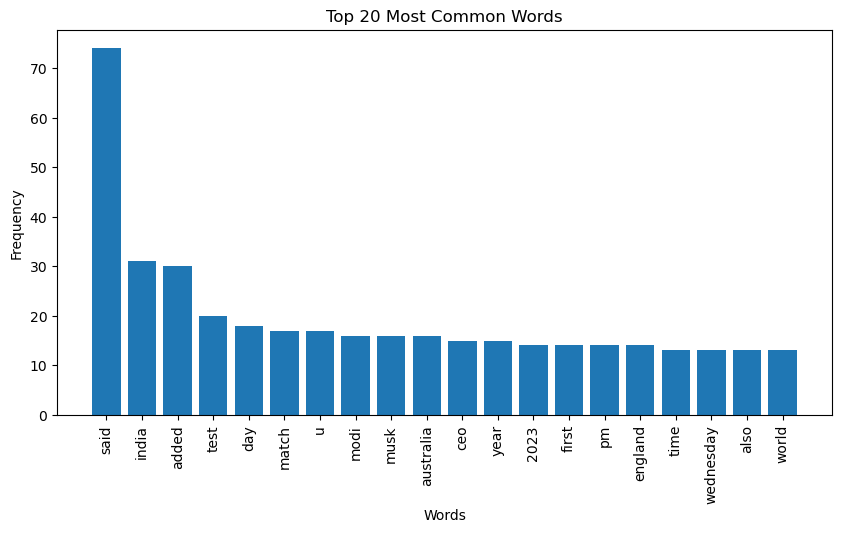

In [18]:
# Get the top 20 most common words
top_words = article_words_freq[:20]

# Create a bar chart of the top 20 words
plt.figure(figsize=(10,5))
plt.bar(top_words.index, top_words.values)
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

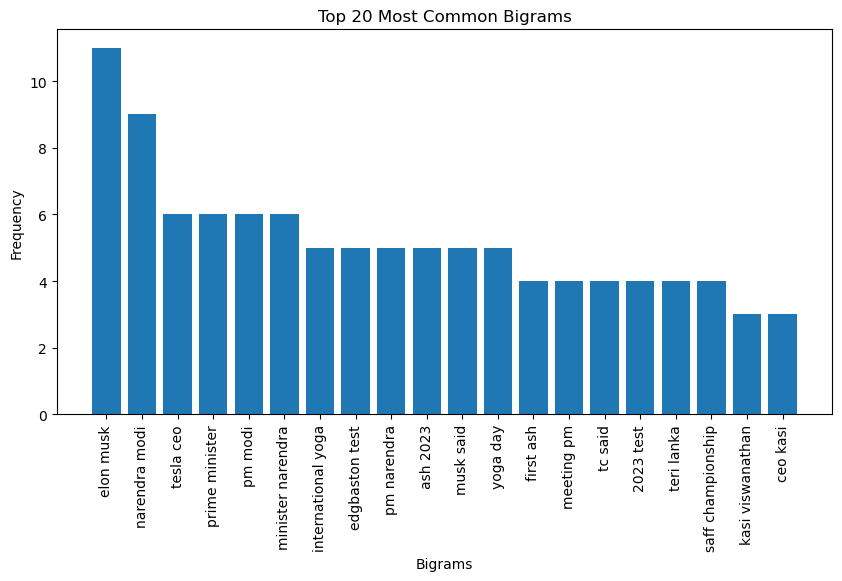

In [23]:
# Create a list of bigrams
bigrams = list(ngrams(article_words, 2))

# Create a series from the list of bigrams
bigram_series = pd.Series(bigrams)

# Get the top 20 most common bigrams
top_bigrams = bigram_series.value_counts().head(20)

# Create a bar chart of the top 20 bigrams
plt.figure(figsize=(10,5))
plt.bar(top_bigrams.index.map(lambda x: ' '.join(x)), top_bigrams.values)
plt.title('Top 20 Most Common Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

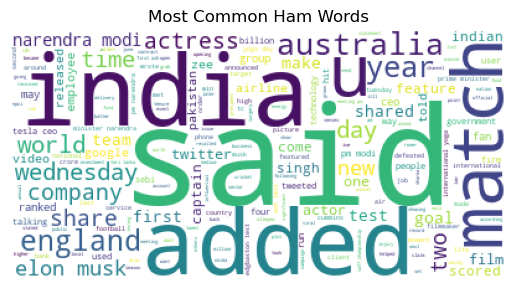

In [24]:
img = WordCloud(background_color='white').generate(' '.join(article_words))

plt.imshow(img)
plt.axis('off')
plt.title('Most Common Ham Words')
plt.show()

## 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.